# Machine Learning - Assignment 3: Classification Models

### Submitted by : 
### Tomer Shahar
### Nevo Itzhak

In this assignment we are given a dataset of clinical trials. We must predict if the patient died or had a cardiovascular event.
The first thing we noticed is how imbalanced the data is - over 93% of the entries are classified as 'False':

In [1]:
from collections import Counter
import pandas as pd

file_path = 'ex3_data.csv'
df = pd.read_csv(file_path)
counter = Counter(df.iloc[:, -1])
print('Original dataset shape %s' % counter)
print('Percentage of True classifications: %s' % (counter[True] / df.shape[0]))
print('Percentage of False classifications: %s' % (counter[False] / df.shape[0]))

Original dataset shape Counter({False: 8207, True: 539})
Percentage of True classifications: 0.06162817287903041
Percentage of False classifications: 0.9383718271209696


This imbalance has to be dealt with in the training phase. However, the first thing we must do is parse and preprocess the data. We did several things to clean it up:
1. We shuffled the data to ensure that there is no bias and the rows aren't in a certain order
2. We dropped any rows where the class is undefined.
3. We dropped rows where more than 20% of the features are undefined.
4. We encoded the nominal labels.
5. For any row that has <20% missing features, we filled them in with the 10 nearest neighbors using K-nearest neighbors
6. We used a standard scaler in order to scale the data to a standard normal distribution.
7. And finally we used a SMOTE library to generate new rows with the class "True". Note that this is done ONLY on the train, and not on the test.
Note that it is incorrect to use SMOTE on anything besides the training data. Using SMOTE to correct the imbalance of the test set results in synthetic entries that shouldn't exist. This is crucial because the imbalance of the test set is precisely why it is so difficult.
We then perform a split into test/train.

Number of records at the beginning, before the pre-processing 8746
Removed 0 records without class
Removed 0 records with at least 20.0% non-NaNs


C:\Users\Tomer\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Tomer\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


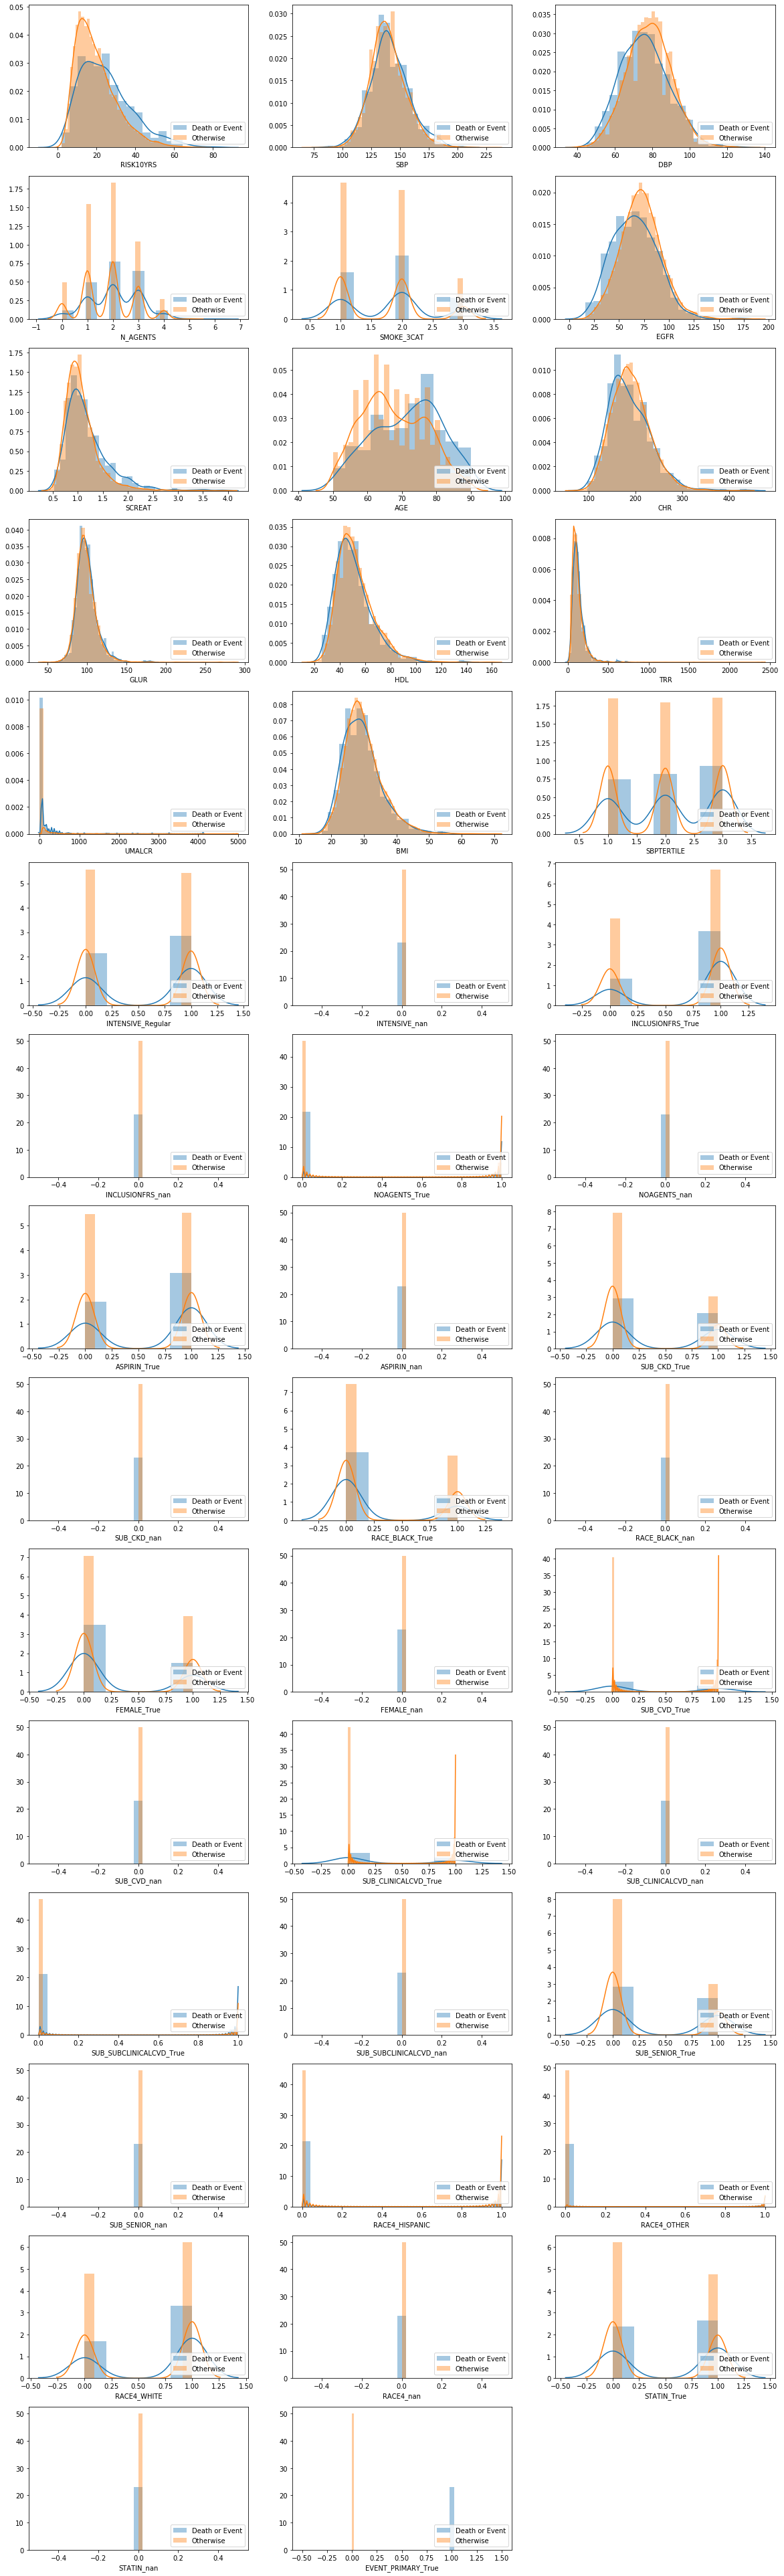

In [8]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

def parse_data_one_hot_encoding(data_path):
    """
    Parses the data, i.e. normalization and labeling.
    :param data_path: The data frame
    :return: A clean data frame.
    """
    df = pd.read_csv(data_path)
    df = df.drop(['NEWSITEID'], axis=1)
    df = df.sample(frac=1, random_state=101)  # SHUFFLE
    last_len_df = len(df)
    print(f'Number of records at the beginning, before the pre-processing {last_len_df}')
    df = df.dropna(subset=['EVENT_PRIMARY'])  # Drop NA from Y
    print(f'Removed {last_len_df - len(df)} records without class')
    last_len_df = len(df)
    non_na_prec = 0.2
    df = df.dropna(thresh=int(df.shape[0] * non_na_prec), axis=1)  # Only drop columns which have at least X% non-NaNs
    print(f'Removed {last_len_df - len(df)} records with at least {non_na_prec*100}% non-NaNs')
    df = pd.get_dummies(df,
                        columns=['INTENSIVE', 'INCLUSIONFRS', 'NOAGENTS', 'ASPIRIN', 'SUB_CKD', 'RACE_BLACK',
                                 'FEMALE', 'SUB_CVD', 'SUB_CLINICALCVD', 'SUB_SUBCLINICALCVD', 'SUB_SENIOR',
                                 'RACE4', 'STATIN'],
                        drop_first=True,
                        dummy_na=True)
    df = pd.get_dummies(df, columns=['EVENT_PRIMARY'], drop_first=True)
    # Use 10 nearest rows which have a feature to fill in each row's missing features
    imputer = KNNImputer(n_neighbors=10)
    imputer.fit(df)
    df[:] = imputer.transform(df)
    fig = plt.figure(figsize=(20, 70))
    for i, col in enumerate(df.columns):
        ax = fig.add_subplot(15, 3, i+1)
        #plt.figure(i)
        sns.distplot(df[df['EVENT_PRIMARY_True']==1][col], label='Death or Event', ax=ax)
        sns.distplot(df[df['EVENT_PRIMARY_True']==0][col], label='Otherwise', ax=ax)
        plt.legend(loc='lower right')

    plt.show()
    
    df = df.drop(['SBP', 'GLUR', 'HDL', 'CHR', 'TRR'], axis=1)
    split = 1 / 5
    y = pd.DataFrame(df.iloc[:, -1])
    x = pd.DataFrame(df.iloc[:, :-1])
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=split, random_state=101)
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    sm = SMOTE(random_state=0)  # ONLY THE TRAIN SET!!
    x_train, y_train = sm.fit_sample(x_train, y_train.iloc[:, 0])
    
    return x_train, x_test, y_train, y_test

train_x, test_x, train_y, test_y = parse_data_one_hot_encoding(file_path)

## Running the classifiers

Now that the data is all polished and ready to go, we built our classifiers. For each classifier we used gridsearch with Cross Validation in order to find the best hyperparameters, and then we tested the trained model provided by gridsearch on the test set.

Note that at the end of each block of code we print some quantative scores.

In [3]:
# Libraries used for all classifiers
n_jobs = 6  # Number of simultaneous cores to use when using gridsearch
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
import time


In [4]:
from sklearn.linear_model import LogisticRegression

def perform_logistic_regression(x_train, x_test, y_train, y_test, print_params=False):
    """
    Uses logistic regression to predict the class
    :param print_params: Flag to decide if we print the grid search results or not
    :return: Accuracy metrics
    """
    np.random.seed(0)
    parameters = {'solver': ('lbfgs', 'liblinear', 'sag', 'newton-cg'), 'max_iter': (10000, 20000, 50000, 100000),
                  'tol': (1e-3, 1e-2, 1e-1)}
    clf = GridSearchCV(estimator=LogisticRegression(), param_grid=parameters, cv=10, scoring='roc_auc', n_jobs=-1)
    fit_start_time = time.time()
    clf.fit(x_train, y_train)
    learning_time = time.time() - fit_start_time
    if print_params:
        print('**** Best Logistic Regression Parameters: ****')
        print(clf.best_params_)
        print('Best score:', clf.best_score_)

    pred_start_time = time.time()
    pred = clf.predict(x_test)
    prediction_time = time.time() - pred_start_time
    acc = accuracy_score(y_test, pred)
    y_score = clf.predict_proba(x_test)[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_score)
    auc = metrics.auc(fpr, tpr)
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    prauc = metrics.auc(recall, precision)
    f1 = metrics.f1_score(y_test, pred)
    print(f'Logistic Regression Accuracy: {acc}\nAUC: {auc}\nPRAUC: {prauc}\nF1 Score: {f1}\n'
          f'Learning Time: {learning_time} seconds\nPrediction Time: {prediction_time} seconds')
    print(metrics.classification_report(y_test, pred, target_names=['Death or Event', 'Otherwise']))
    return acc, fpr, tpr, auc, precision, recall, prauc

lr_acc, lr_fpr, lr_tpr, lr_auc, lr_precision, lr_recall, lr_prauc = perform_logistic_regression(train_x, test_x, train_y, test_y, print_params=True)

**** Best Logistic Regression Parameters: ****
{'max_iter': 20000, 'solver': 'sag', 'tol': 0.01}
Best score: 0.7171220791329177
Logistic Regression Accuracy: 0.6605714285714286
AUC: 0.698068150109344
PRAUC: 0.15217993980235597
F1 Score: 0.1610169491525424
Learning Time: 13.81183409690857 seconds
Prediction Time: 0.0 seconds
                precision    recall  f1-score   support

Death or Event       0.97      0.66      0.79      1657
     Otherwise       0.09      0.61      0.16        93

      accuracy                           0.66      1750
     macro avg       0.53      0.64      0.47      1750
  weighted avg       0.92      0.66      0.75      1750



In [9]:
from sklearn.ensemble import RandomForestClassifier

def perform_random_forest(x_train, x_test, y_train, y_test, print_params=False):
    """
    Uses the popular ensemble decision tree classifier random forest.
    :param print_params: Flag to decide if we print the grid search results or not
    :return: Accuracy metrics.
    """
    parameters = {'bootstrap': [True], 'ccp_alpha': [0.0], 'class_weight': [None], 'criterion': ['gini'],
                  'max_depth': [15, None], 'max_features': ['auto', None], 'max_leaf_nodes': [None],
                  'max_samples': [None], 'min_impurity_decrease': [0.0], 'min_samples_leaf': [1],
                  'min_samples_split': [2], 'min_weight_fraction_leaf': [0.0], 'n_estimators': [100],
                  'oob_score': [False], 'verbose': [0], 'warm_start': [False], 'random_state': [101]}
    clf = GridSearchCV(estimator=RandomForestClassifier(),
                       param_grid=parameters, cv=5, scoring='roc_auc', n_jobs=n_jobs)
    fit_start_time = time.time()
    clf.fit(x_train, y_train)
    learning_time = time.time() - fit_start_time
    if print_params:
        print('**** Best Random Forest Parameters: ****')
        print(clf.best_params_)
        print('Best score:', clf.best_score_)

    pred_start_time = time.time()
    pred = clf.predict(x_test)
    prediction_time = time.time() - pred_start_time
    acc = accuracy_score(y_test, pred)
    y_score = clf.predict_proba(x_test, )[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_score)
    auc = metrics.auc(fpr, tpr)
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    prauc = metrics.auc(recall, precision)
    f1 = metrics.f1_score(y_test, pred)
    print(f'Random Forest Accuracy: {acc}\nAUC: {auc}\nPRAUC: {prauc}\nF1 Score: {f1}\n'
          f'Learning Time: {learning_time} seconds, Prediction Time: {prediction_time} seconds')
    print(metrics.classification_report(y_test, pred, target_names=['Death or Event', 'Otherwise']))
    return acc, fpr, tpr, auc, precision, recall, prauc

rf_acc, rf_fpr, rf_tpr, rf_auc, rf_precision, rf_recall, rf_prauc = perform_random_forest(train_x, test_x, train_y, test_y, print_params=True)

**** Best Random Forest Parameters: ****
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'oob_score': False, 'random_state': 43, 'verbose': 0, 'warm_start': False}
Best score: 0.9961612376901113
Random Forest Accuracy: 0.9394285714285714
AUC: 0.6970915179005976
PRAUC: 0.10862994005137674
F1 Score: 0.08620689655172414
Learning Time: 9.047999382019043 seconds, Prediction Time: 0.020888328552246094 seconds
                precision    recall  f1-score   support

Death or Event       0.95      0.99      0.97      1657
     Otherwise       0.22      0.05      0.09        93

      accuracy                           0.94      1750
     macro avg       0.58      0.52      0.53      1750
  weighted avg       0.91      0.94      0.92      1750



In [6]:
from sklearn.neural_network import MLPClassifier

def perform_neural_net_classification(x_train, x_test, y_train, y_test, print_params=False):
    """
    Uses logistic regression to predict the class
    :param print_params: Flag to decide if we print the grid search results or not
    :return: Accuracy metrics
    """
    np.random.seed(0)
    parameters = {'solver': ['adam'],
                  'activation': ['relu'],
                  'tol': [1e-2, 1e-1],
                  'hidden_layer_sizes': ((23, 12, 6), (23, 12, 6, 3), (23, 12)),
                  'max_iter': (range(2000, 2001, 100)),
                  'alpha': [0.0001],
                  'learning_rate': ['constant']}
    clf = GridSearchCV(estimator=MLPClassifier(), param_grid=parameters, cv=10, scoring='roc_auc',
                       n_jobs=n_jobs)
    fit_start_time = time.time()
    clf.fit(x_train, y_train)
    learning_time = time.time() - fit_start_time
    if print_params:
        print('**** Best Multi Layer Perceptron Parameters: ****')
        print(clf.best_params_)
        print('Best score:', clf.best_score_)

    pred_start_time = time.time()
    pred = clf.predict(x_test)
    prediction_time = time.time() - pred_start_time
    acc = accuracy_score(y_test, pred)
    y_score = clf.predict_proba(x_test)[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_score)
    auc = metrics.auc(fpr, tpr)
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    prauc = metrics.auc(recall, precision)
    f1 = metrics.f1_score(y_test, pred)
    print(f'Multi-Layer Perceptron Accuracy: {acc}\nAUC: {auc}\nPRAUC: {prauc}\nF1 Score: {f1}\n'
          f'Learning Time: {learning_time} seconds\nPrediction Time: {prediction_time} seconds')
    print(metrics.classification_report(y_test, pred, target_names=['Death or Event', 'Otherwise']))
    return acc, fpr, tpr, auc, precision, recall, prauc


nn_acc, nn_fpr, nn_tpr, nn_auc, nn_precision, nn_recall, nn_prauc = perform_neural_net_classification(train_x, test_x, train_y, test_y, print_params=True)

**** Best Multi Layer Perceptron Parameters: ****
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (23, 12, 6), 'learning_rate': 'constant', 'max_iter': 2000, 'solver': 'adam', 'tol': 0.01}
Best score: 0.8739176038692384
Multi-Layer Perceptron Accuracy: 0.7622857142857142
AUC: 0.6073289595784582
PRAUC: 0.08432727271458473
F1 Score: 0.1510204081632653
Learning Time: 11.976254940032959 seconds
Prediction Time: 0.0009975433349609375 seconds
                precision    recall  f1-score   support

Death or Event       0.96      0.78      0.86      1657
     Otherwise       0.09      0.40      0.15        93

      accuracy                           0.76      1750
     macro avg       0.53      0.59      0.51      1750
  weighted avg       0.91      0.76      0.82      1750



## Quantative Comparison

Because of the imbalance of the test, we cannot simply judge the classifiers by their accuracy. It is quite irrelevant in our case. So instead, we compare them also by their ROC-AUC scores, which show how many false positive we get for each classifier. For example, a classifier that always returns "False" would have a very high accuracy of 93%~, but a terrible ROC because it would get false positives all the time.
Additionally, we added the Precision and Recall ROC (PRAUC). These are good indicators for a classifier when we have a greatly imbalanced dataset. They can often detect differences that traditional ROC cannot. This is because ROC takes into account the True Negative Rate which is most of the dataset, while PRAUC doesn't.

Explanations here:
http://pages.cs.wisc.edu/~jdavis/davisgoadrichcamera2.pdf

https://www.kaggle.com/lct14558/imbalanced-data-why-you-should-not-use-roc-curve

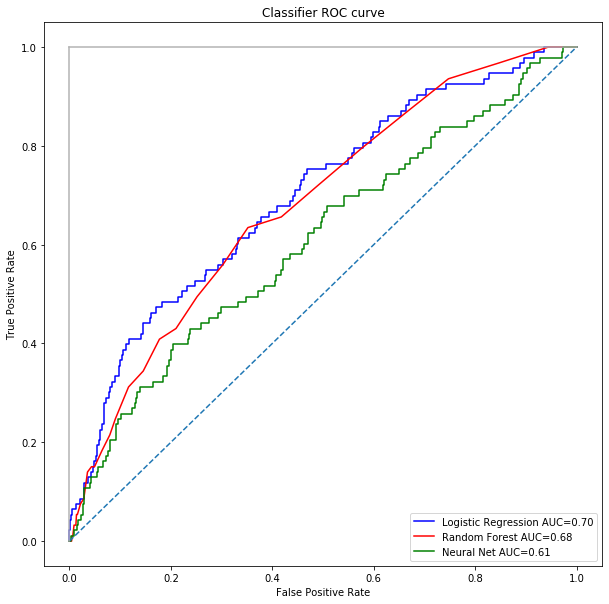

<Figure size 432x288 with 0 Axes>

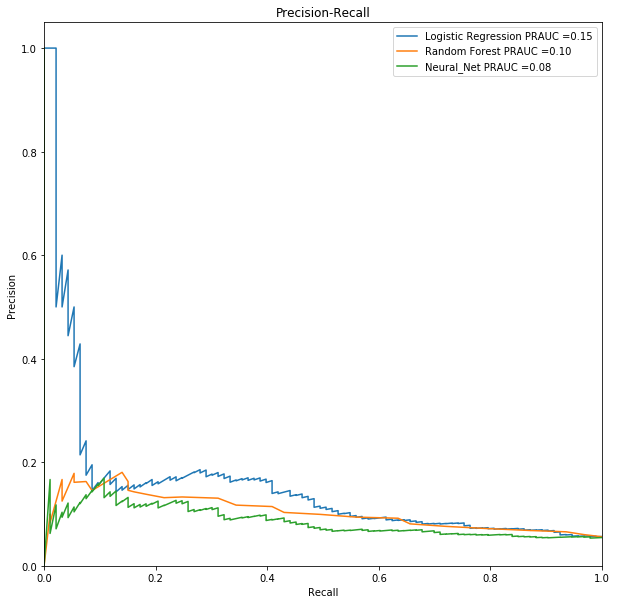

In [7]:

plt.subplots(1, figsize=(10, 10))
plt.title('Classifier ROC curve')
plt.plot(lr_fpr, lr_tpr, 'b', label='Logistic Regression AUC=%0.2f' % lr_auc)
plt.plot(rf_fpr, rf_tpr, 'r', label='Random Forest AUC=%0.2f' % rf_auc)
plt.plot(nn_fpr, nn_tpr, 'g', label='Neural Net AUC=%0.2f' % nn_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

plt.clf()
plt.subplots(1, figsize=(10, 10))
plt.plot(lr_recall, lr_precision, label='Logistic Regression PRAUC =%0.2f' % lr_prauc)
plt.plot(rf_recall, rf_precision, label='Random Forest PRAUC =%0.2f' % rf_prauc)
plt.plot(nn_recall, nn_precision, label='Neural_Net PRAUC =%0.2f' % nn_prauc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall')
plt.legend(loc="upper right")
plt.show()

Note that the PRAUC rate is not comparable to accuracy or ROC and is always substantially lower. However it helps us compare between different classifiers.


## Qualitative Comparison:
Here are some qualitative comparisons between the different classifiers.

1. Easy Tuning: Logical Regression is the easiest to tune, following by Random Forest and then MLP. MLP is very difficult to tune as it involved a deep neural network architecture which we only have "rules of thumb" to follow in order to design it. MLP might have the potential to be an amazing classifier but that doesn't help us if we never find the right parameters. Random Forest is much harder to tune than LR but much easier than MLP. It is a good compromise.
2. Interpretability: Random Forest is easiest to interpret. Logistic Regression is also fine, since we can peek at the weights given to each feature to compare how important it is. MLP is of course the hardest to interpret since we cannot really explain the reason for the weights of each neuron.
3. Robustness: Logistic Regression and Random Forest are fairly robust. We didn't need to fine-tune them precisely to this dataset. MLP is very domain specific since the number of neurons in each hidden layer was derived from the number of features. The same MLP might work very bad if someone were to suddenly add or remove some features from the same dataset.
4. Data type: Random Forest can work with almost all data types and is not sensitive to this. Logistic Regression and MLP however require numerical data.
5